# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

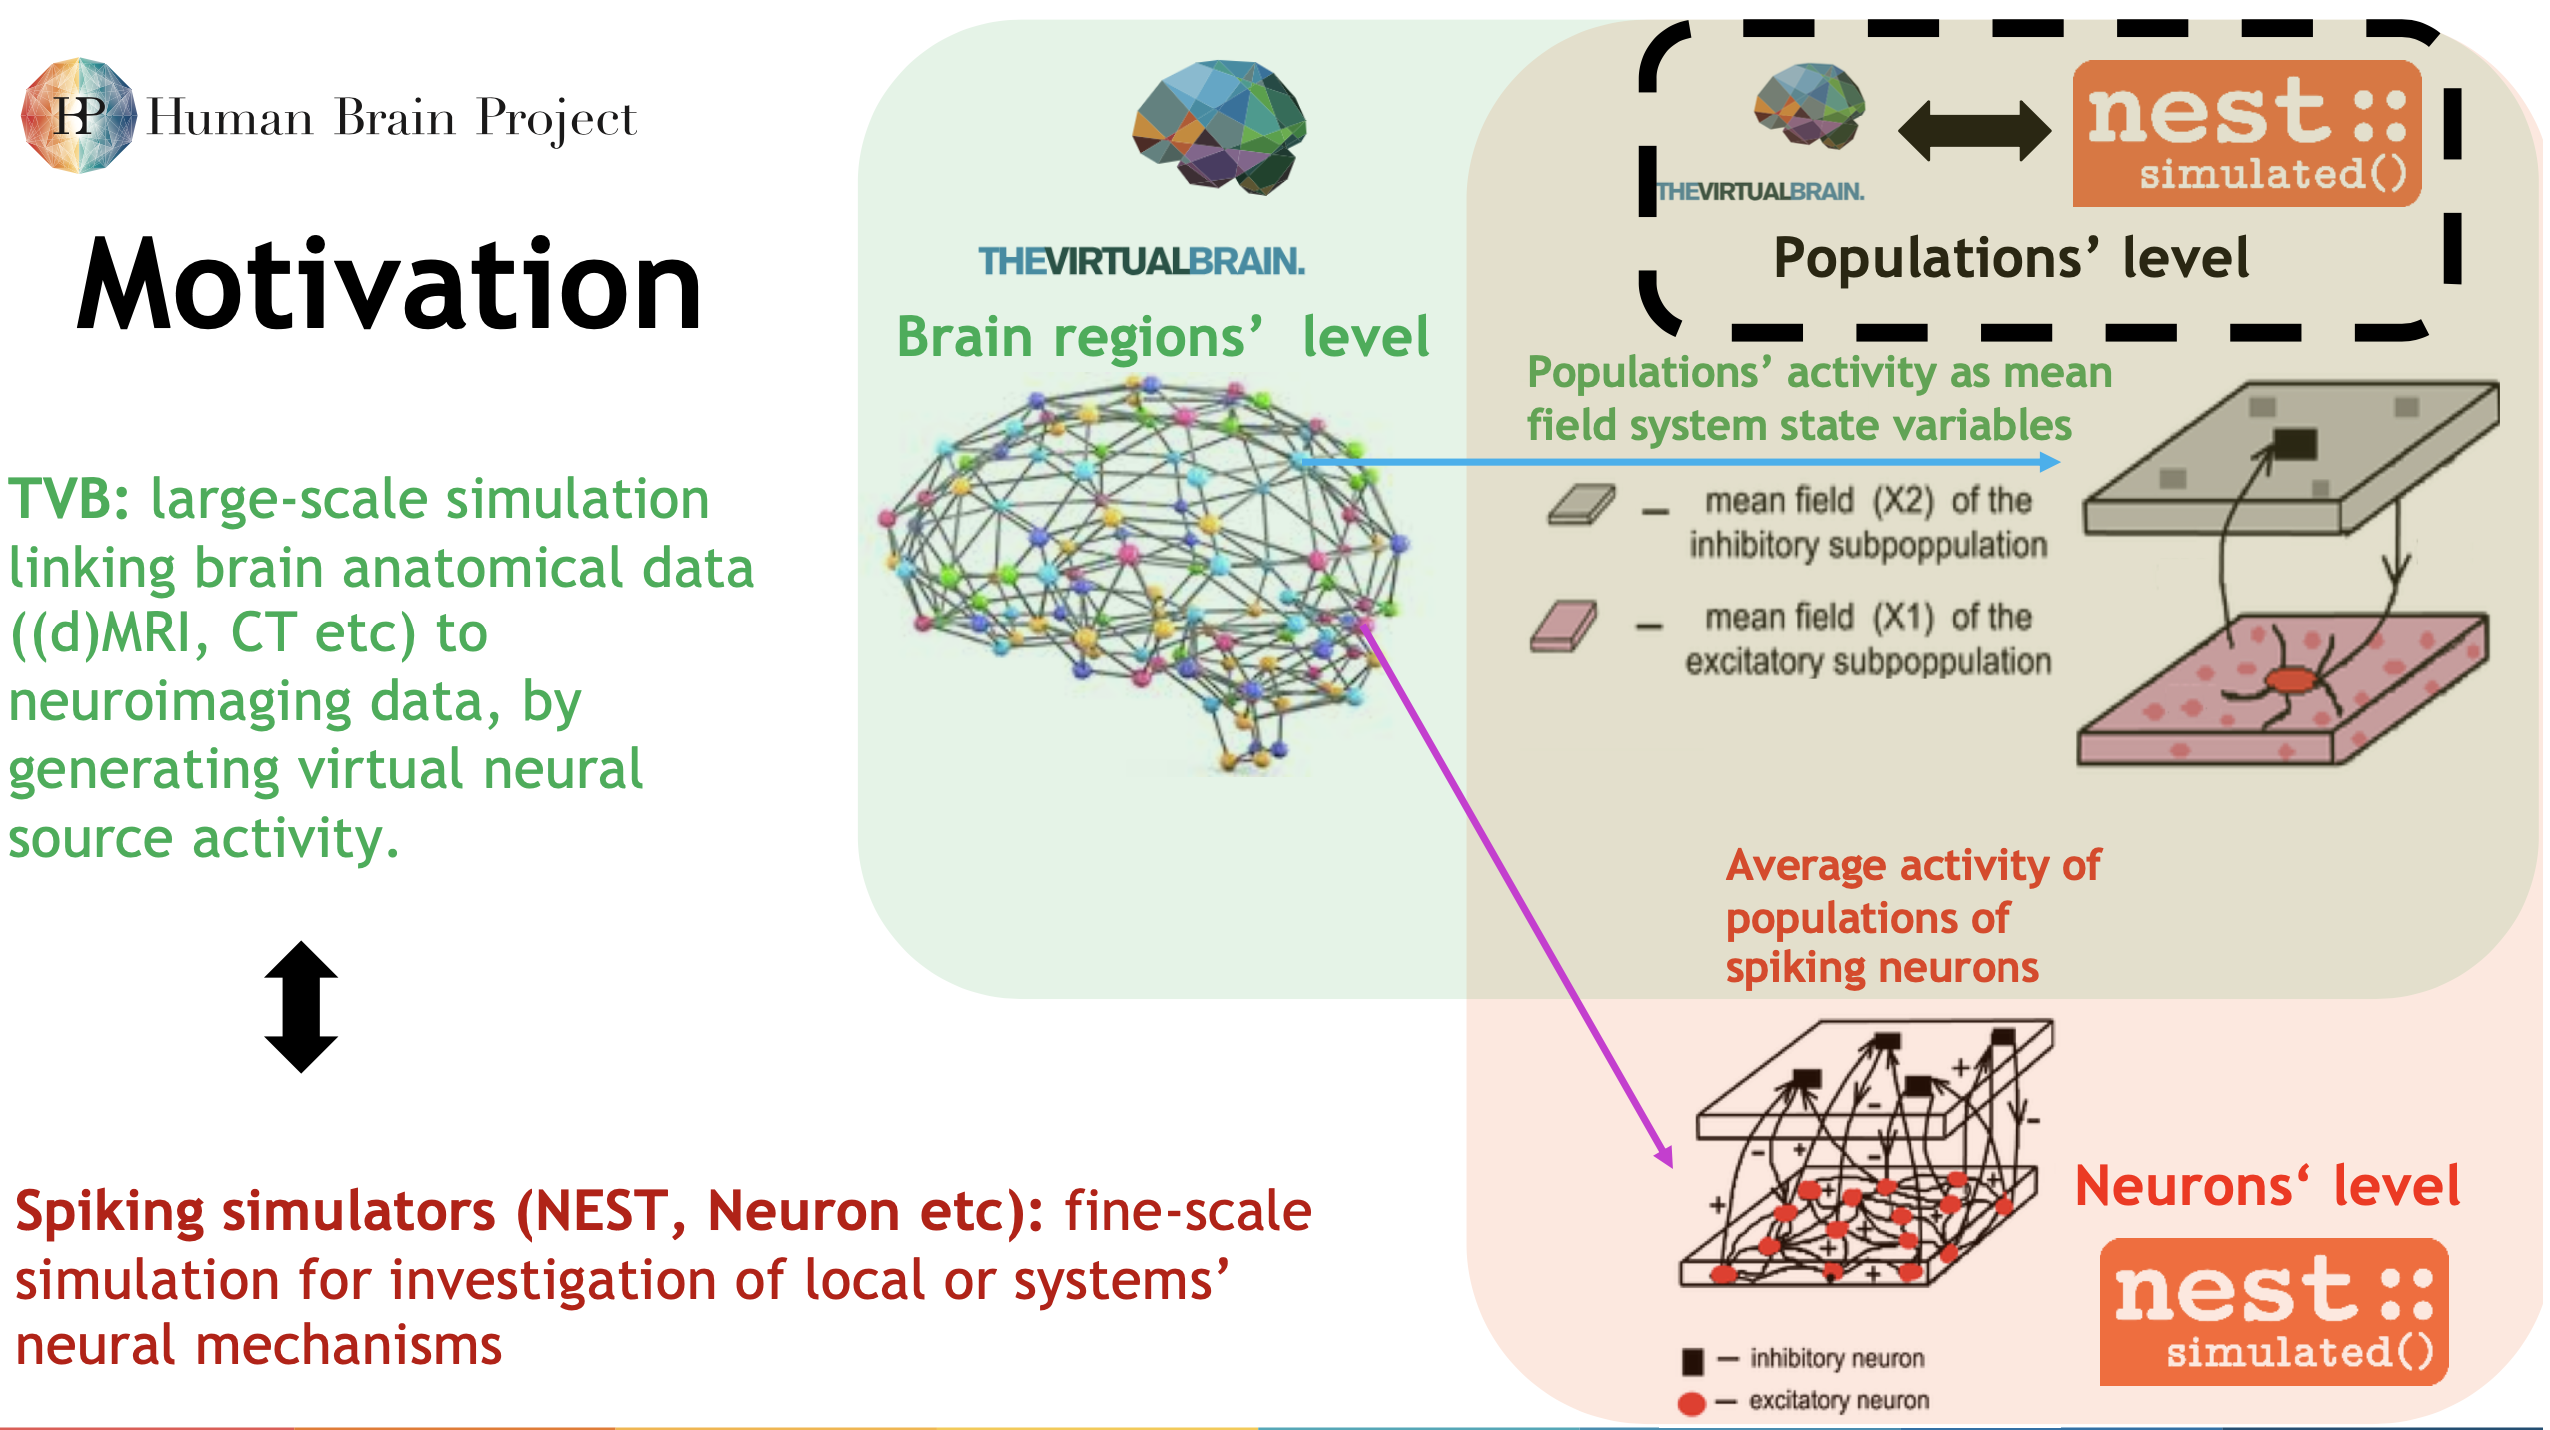

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./pics/ConceptGraph.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

We demonstrate a multiscale simulation <br> of a reduced Wong-Wang model [3, 4] <br> using TVB [1, 2] for brain regions modelled at coarse scale, <br> and NEST [5] for regions modelled as <br> networks of spiking neural populations [6,7]

## Reduced Wong-Wang TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + (1-{S_{n\prime}}(t))\gamma {R_{n\prime}}(t)$

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}a_c\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- multiplicative coefficient of TVB's linear ($a_c*x + b_c$) coupling function $a_c=1.0/256$, 
  assuming $b_c=0.0$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C - g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e$

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ Ga_c\sum_{n\prime n}C_{n\prime \neq n}\left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


# WORKFLOW:

In [2]:
import os
from collections import OrderedDict
import time
import numpy as np

# Importing and setting LIBRARY_PROFILE for TVB scripting
from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

# Importing and setting some configurations for tvb_multiscale and tvb_nest
from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "basal_ganglia_conn")
outputs_path = os.path.join(work_path, "outputs/BasalGanglia")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

# Importing and creating a Plotter class object
from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 


## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)


Connectome used for simulations: 
Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections


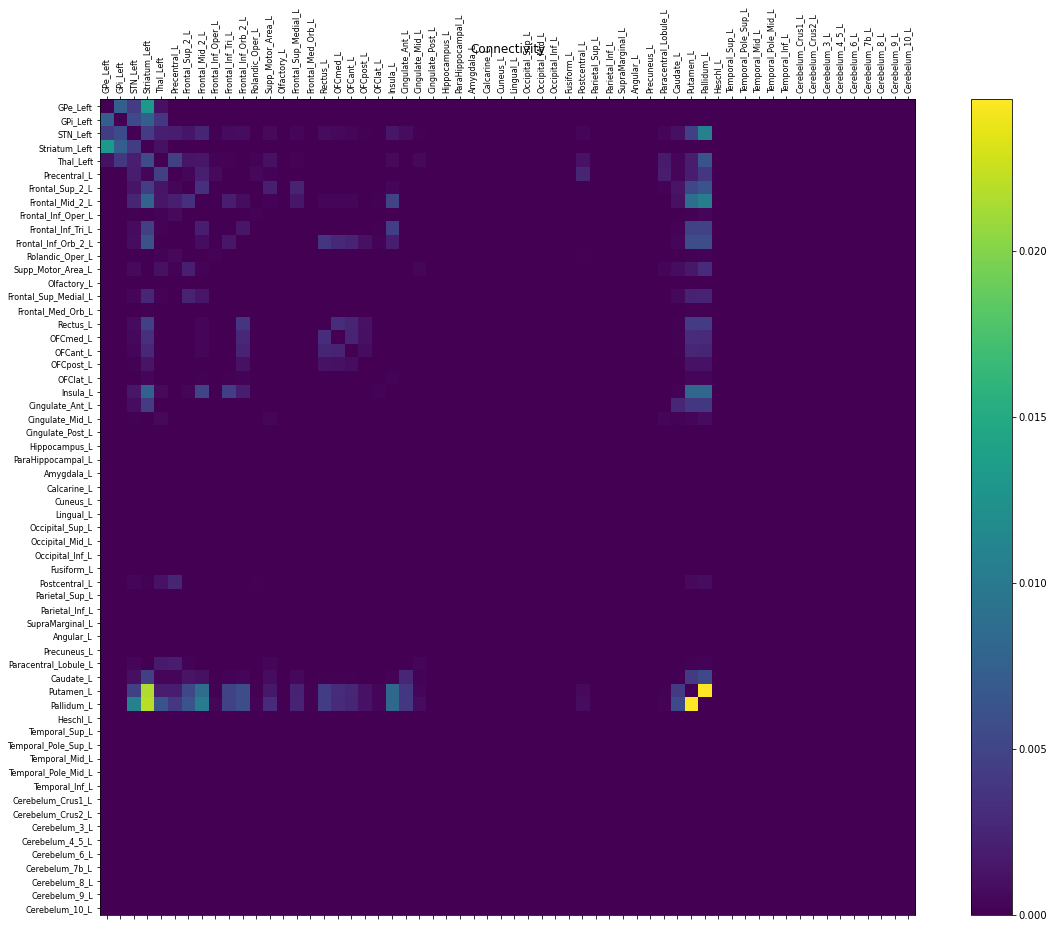

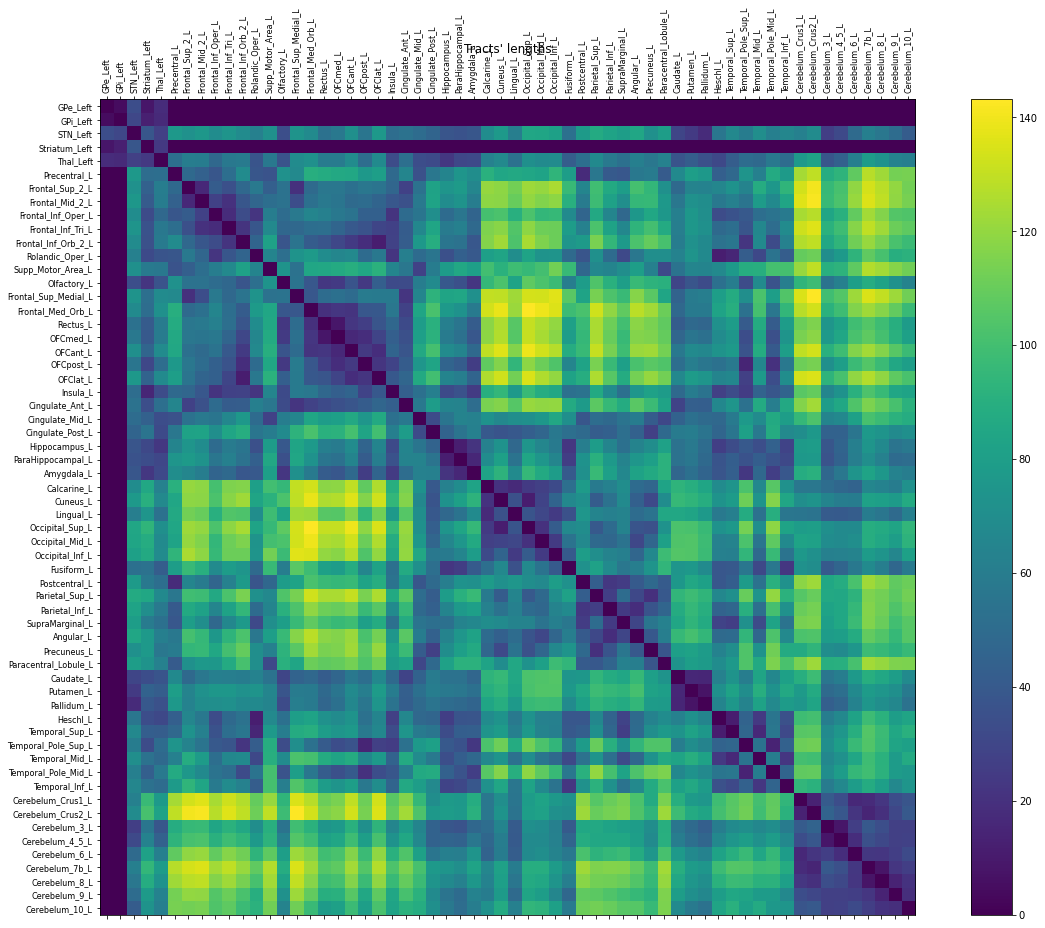

In [3]:
from tvb.datatypes.connectivity import Connectivity

# Load full TVB connectome connectivity

# Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas, see [8].
# (We have removed the right hemisphere and processes/removed a few regions and connections.)
# weights:
weights = np.loadtxt(os.path.join(data_path, "weights.txt"))  
# Cheating a bit by increasing the Thal -> Striatum connection for this example to run!
weights[4,3] *= 5.0  
# tract lengths:
tract_lengths = np.loadtxt(os.path.join(data_path, "tract_lengths.txt"))
# region centers 3D coordinates:
centers = np.loadtxt(os.path.join(data_path, "regions.txt"), usecols=range(1,4))  
# region labels:
region_labels = np.loadtxt(os.path.join(data_path, "regions.txt"), dtype="str", usecols=(0,))

connectivity = Connectivity(region_labels=region_labels, centres=centers,
                            weights=weights, tract_lengths=tract_lengths)
# a scaling of TVB weights specific to this use case
scaleBGoptTOtvb = 0.00205875  
connectivity.weights *= scaleBGoptTOtvb
# setting the transmission speed along white matter tracts:
connectivity.speed = np.array([4.0])  
connectivity.configure() # configure now in order to plot

from tvb.simulator.cosimulator import CoSimulator
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO
simulator.model = ReducedWongWangExcIO(**model_params)

# Setting the connectivity:
simulator.connectivity = connectivity

#Setting the coupling function:
from tvb.simulator.coupling import Linear
# TVB linear coupling of the form: a*x + b with default values of a = 1.0/256 and b = 0.0
simulator.coupling = Linear(a=np.array([1.0/256]), b=np.array([0.0]))

# Setting the integrator:
from tvb.simulator.integrators import HeunStochastic
simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1 # the TVB time step of integration
simulator.integrator.noise.nsig = np.array([1e-6]) # the amplitude (standard deviation) of noise 

# Setting a tuple of TVB monitors
from tvb.simulator.monitors import Raw  # , Bold, EEG
# Raw monitor records all state variables of the model
mon_raw = Raw(period=1.0)  # sampling period in ms
simulator.monitors = (mon_raw, )  # , Bold, EEG

# Setting initial conditions
# convert time delays to integration step delays:
simulator.connectivity.set_idelays(simulator.integrator.dt) 
# determine the history horizon (past states buffer)
simulator.horizon = simulator.connectivity.idelays.max() + 1
# Load initial conditions
init_cond = np.load(os.path.join(data_path, "tvb_init_cond_left_noVermis.npy")) 
# The initial conditions must have a shape of 
# (past_time_horizon, number_of_variables, number_of_regions, number_of_modes)
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))

print("\nConnectome used for simulations: \nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections")
plotter.plot_tvb_connectivity(simulator.connectivity);


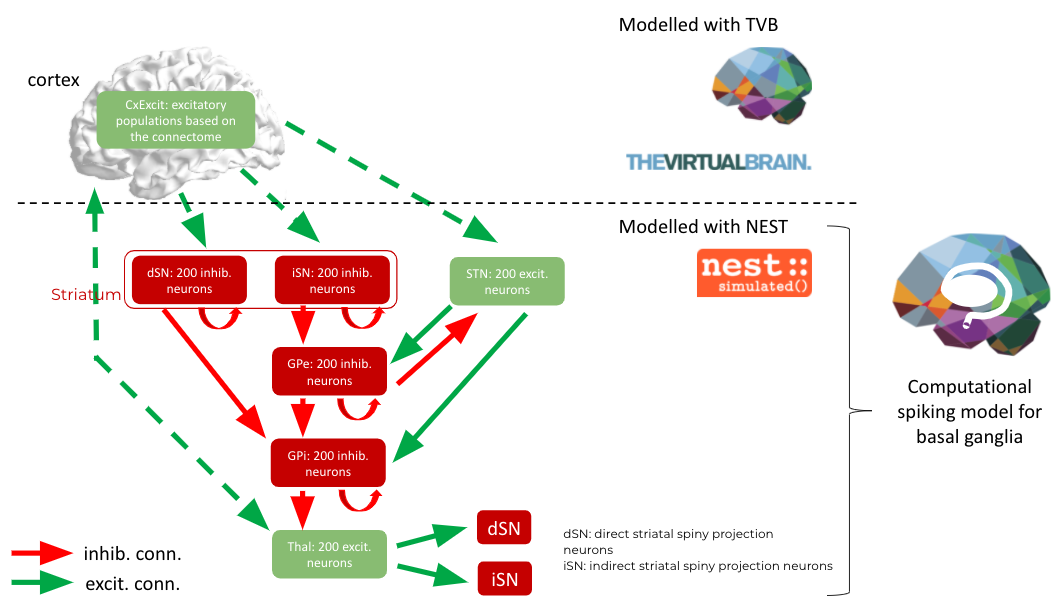

In [4]:
display(Image(filename='./pics/BG_Net.png',  width=1000, unconfined=False))

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [5]:
from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Select the regions for the fine scale modeling with NEST spiking networks
nest_nodes_ids = [0, 1, 2, 3, 4]  

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config, set_defaults=False)

nest_model_builder.population_order = 200  # scalable population size

# We fix the global_coupling_scaling manually for this use-case:
nest_model_builder.global_coupling_scaling = 1.0

# Using all default parameters for this example
# nest_model_builder.set_defaults()

# or...

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------When uncommented below, configuring the builder manually:---------------------------
# ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy


# 1. Populations' configurations

population_neuron_model = "izhikevich_hamker"  # the NEST spiking neuron model used

# Common parameters for all populations:
nest_model_builder.params_common = \
    {"E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0, 
     "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

# Common parameters for excitatory populations:
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
# Common parameters for inhibitory populations:
nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
# Striatum parameters:
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_th": 40.0, "C_m": 50.0,
                                     "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

# Setting the indices of each spiking region:
nest_model_builder.Igpe_nodes_ids = [0]
nest_model_builder.Igpi_nodes_ids = [1]
nest_model_builder.Istr_nodes_ids = [3]
nest_model_builder.Estn_nodes_ids = [2]
nest_model_builder.Eth_nodes_ids = [4]

# Concatenating all excitatory and inhibitory spiking regions' indices:
# I populations: Igpi and Igpe
I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids 
# E populations: Estn and Eth
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids 

# Functions to modify parameters for excitatory and inhibitory spiking regions', respectively:
def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})  # 12.0
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})  # 30.0
    return paramsI
    
# When any of the properties model, params and scale 
# depends on regions, set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0}, 
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0}, 
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]



# 2. Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type 
# depend on the regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"  # the synapse model, 
                                  # NEST static_synapse just multiplies presynaptic spikes with a weight
# Dict of properties of connections among neurons:
conn_spec = {'rule': "all_to_all", "allow_autapses": True, 
#              # parameters relating to other connectivity rules:
#              "allow_multapses": True, 
#              "indegree": None, "outdegree": None, "N": None, "p": 0.1  
            }

# Default within region delay 
nest_model_builder.default_min_delay = 0.1 # ms

# for each connection, we have a different probability
nest_model_builder.populations_connections = [
# #      #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe", "Igpi" and CxI
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -scaleBGoptTOtvb, "delay": nest_model_builder.default_min_delay, "receptor_type": 0, 
     "nodes": I_nodes_ids,
    },  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -scaleBGoptTOtvb, "delay": nest_model_builder.default_min_delay, "receptor_type": 0, 
     "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": -scaleBGoptTOtvb, "delay": nest_model_builder.default_min_delay, "receptor_type": 0, 
     "nodes": nest_model_builder.Istr_nodes_ids},
    ]



# 3. Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

# We define a class instead of a function in this example:
class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    sign = 1

    def __init__(self, sign=1, scale=nest_model_builder.global_coupling_scaling):
        self.sign = sign
        self.global_coupling_scaling = scale * self.sign
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, 
                   tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# When any of the properties model, conn_spec, weight, delay, receptor_type 
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)
nest_model_builder.nodes_connections = [
#     #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe", "Igpi"]
     "model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(), "delay": tvb_delay_fun, "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids},
     ]


# 4. Create a current stimulus input device
nest_model_builder.input_devices = [

# ---- (Un)Comment below for (DBS stimulation) Resting State simulation respectively-----
#      {"model": "dc_generator",  # the NEST device model
#       # parameters of the device:
#      "params": { "amplitude": -200.0, "start": 70.0, "stop": 170.0 },  
#       # connections between the devices and the target populations
#      #          stimulus label -> target populations labels
#      "connections": {"DBS_GPi": ["I"]}, 
#      "nodes": nest_model_builder.Igpi_nodes_ids, # "GPi"
#      "weights": 1.0, "delays": 0.0},
# ---------------------------------------------------------------------------------------
    {"model": "poisson_generator",
     "params": {"rate": 500.0, "origin": 0.0, "start": 0.1},
     "connections": {"BaselineStriatum": ["IdSN", "IiSN"]},  
     "nodes": nest_model_builder.Istr_nodes_ids,  # Striatum
     "weights": 1.0, "delays": 0.0, "receptor_type": 1}
       ]  #


# 5. Creating  devices to be able to observe NEST activity:
nest_model_builder.output_devices = []

# Spike recorders:
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "memory"},
         "connections": connections, "nodes": pop["nodes"]})  
    
# NOTE!!: Labels have to be different for different devices!!

# Multimeters to record continuous time variables:
connections = OrderedDict({})
params = {"interval": 1.0, #ms
          "record_to": "memory",
          'record_from': ["V_m", "U_m",
                          "I", "I_syn", "I_syn_ex", "I_syn_in", 
                          "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  
    

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()


2021-01-22 18:17:25,780 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2021-01-22 18:17:25,780 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2021-01-22 18:17:25,782 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/jovyan/env/neurosci/nest_build
2021-01-22 18:17:25,782 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/jovyan/env/neurosci/nest_build
2021-01-22 18:17:25,783 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/jovyan/env/neurosci/nest_build/share/nest
2021-01-22 18:17:25,783 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/jovyan/env/neurosci/nest_build/share/nest
2021-01-22 18:17:25,785 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/jovyan/env/neurosci/nest_build/share/doc/nest
2021-01-22 18:17:25,785 - INFO - tvb_multiscale.t

2021-01-22 18:17:25,900 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-01-22 18:17:25,900 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-01-22 18:17:26,082 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-01-22 18:17:26,082 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-01-22 18:17:26,257 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for I_spikes created!
2021-01-22 18:17:26,257 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for I_sp

In [6]:
populations_sizes = []
print("Population sizes: ")
for pop in nest_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    
# # Print a summary report of the NEST network and, optionally, its connectivity:
# print(nest_network.print_str(connectivity=True))


Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


## 3. Build the TVB-NEST interface

In [7]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "current" # ??A1, B1, C1??
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----------------------------When uncommented below, configuring the builder manually:---------------------------
# ----------------------------------------------------------------------------------------------------------------

# 1. Some basic configurations on conversions and scalings between the coarse and fine scale!:

tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_recorder the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# and the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# Converting S to current and adjusting units (nA of TVB -> pA of NEST)
tvb_nest_builder.w_tvb_to_current = 1000 * tvb_nest_builder.tvb_model.J_N[0]  


tvb_nest_builder.tvb_to_spikeNet_interfaces = []


tvb_weight_fun = TVBWeightFun(scale=tvb_nest_builder.global_coupling_scaling)


In [8]:
#display(Image(filename='./pics/Rate_BG.png',  width=1000, unconfined=False))

In [9]:
# # TVB -> NEST


# # --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

# # Some configurations for the connectivity from TVB to NEST regions:

# tvb_nest_builder.global_coupling_scaling = 1.0 # G and a dont exist

# if tvb_to_nest_mode == "rate":
#     # Loop for every different spike population and region combination:
#     for trg_pop, target_nodes in zip([["IdSN", "IiSN"],                   "E"],          # ??C2??
#                                       [nest_model_builder.Istr_nodes_ids, E_nodes_ids]): # ??C3??
#         tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
#             {"model": "inhomogeneous_poisson_generator",  # NEST stimulation device to be used   ??C4??
#              "params": {"allow_offgrid_times": False},  # parameters for the NEST device
#         # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
#              "interface_weights": 10.0, # w_{TVB->NEST}                                          # ??C5??
#         # Applied outside NEST for each interface device
#         # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#              "weights": tvb_weight_fun,                                                      # ??C6??
#              "delays": tvb_delay_fun,                                                        # ??C7??
#              "receptor_type": 0, 
#         # --------------------------------------------------------------------------------------------------------------
#         #             TVB sv -> NEST population     
#              "connections": {"R": trg_pop}, # ??C8??: ??C9??
#              "source_nodes": None,          # If None, it means all TVB regions       # ??C10??   
#              "target_nodes": target_nodes}) # If None, it means all NEST regions      # ??C11??    
        

In [10]:
if tvb_to_nest_mode == "current":

    # --For injecting current to NEST neurons via dc generators acting as TVB proxy nodes with TVB delays:--
    
    # Loop for every different spike population and region combination:
    for trg_pop, target_nodes in zip([["IdSN", "IiSN"], "E"],         
                                      [nest_model_builder.Istr_nodes_ids, E_nodes_ids]):  
        tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "dc_generator",  # NEST stimulation device to be used              
             "params": {}, # parameters for the NEST device
        # Properties potentially set as function handles with args (tvb_node_id=None)
        #   Applied outside NEST for each interface device
             "interface_weights": 1.,  # w_{TVB->NEST}                                
        # Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)
             "weights": tvb_weight_fun, # 
             "delays": tvb_delay_fun,  # 
        #                   TVB sv -> NEST population                                 
             "connections": {"S": trg_pop}, # connection from TVB state variable to NEST spiking population
             "source_nodes": None,         # If None, it means all TVB regions         
             "target_nodes": target_nodes})        # If None, it means all NEST regions       


In [11]:

# if tvb_to_nest_mode == "param":

#     # --For directly setting an external current parameter in NEST neurons instantaneously:--
#     # Loop for every different spike population and region combination:
#     for trg_pop, target_nodes in zip(??B2??,           # ??B2??
#                                      ??B3??): # ??B3??
#          tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
#             {"model": ??B4??,  # The type of parameter                                
#              "parameter": ??B5??,  # The name of NEST model parameter to target           
#         # Properties potentially set as function handles with args (tvb_node_id=None)    
#              "interface_weights": ??B6??,  # w_{TVB->NEST}                                
#         #                  TVB sv -> NEST population                                     
#              "connections": {??B7??: ??B8??}, # connection from TVB state variable to NEST spiking population
#              "nodes": ??B9??})                                                      
  

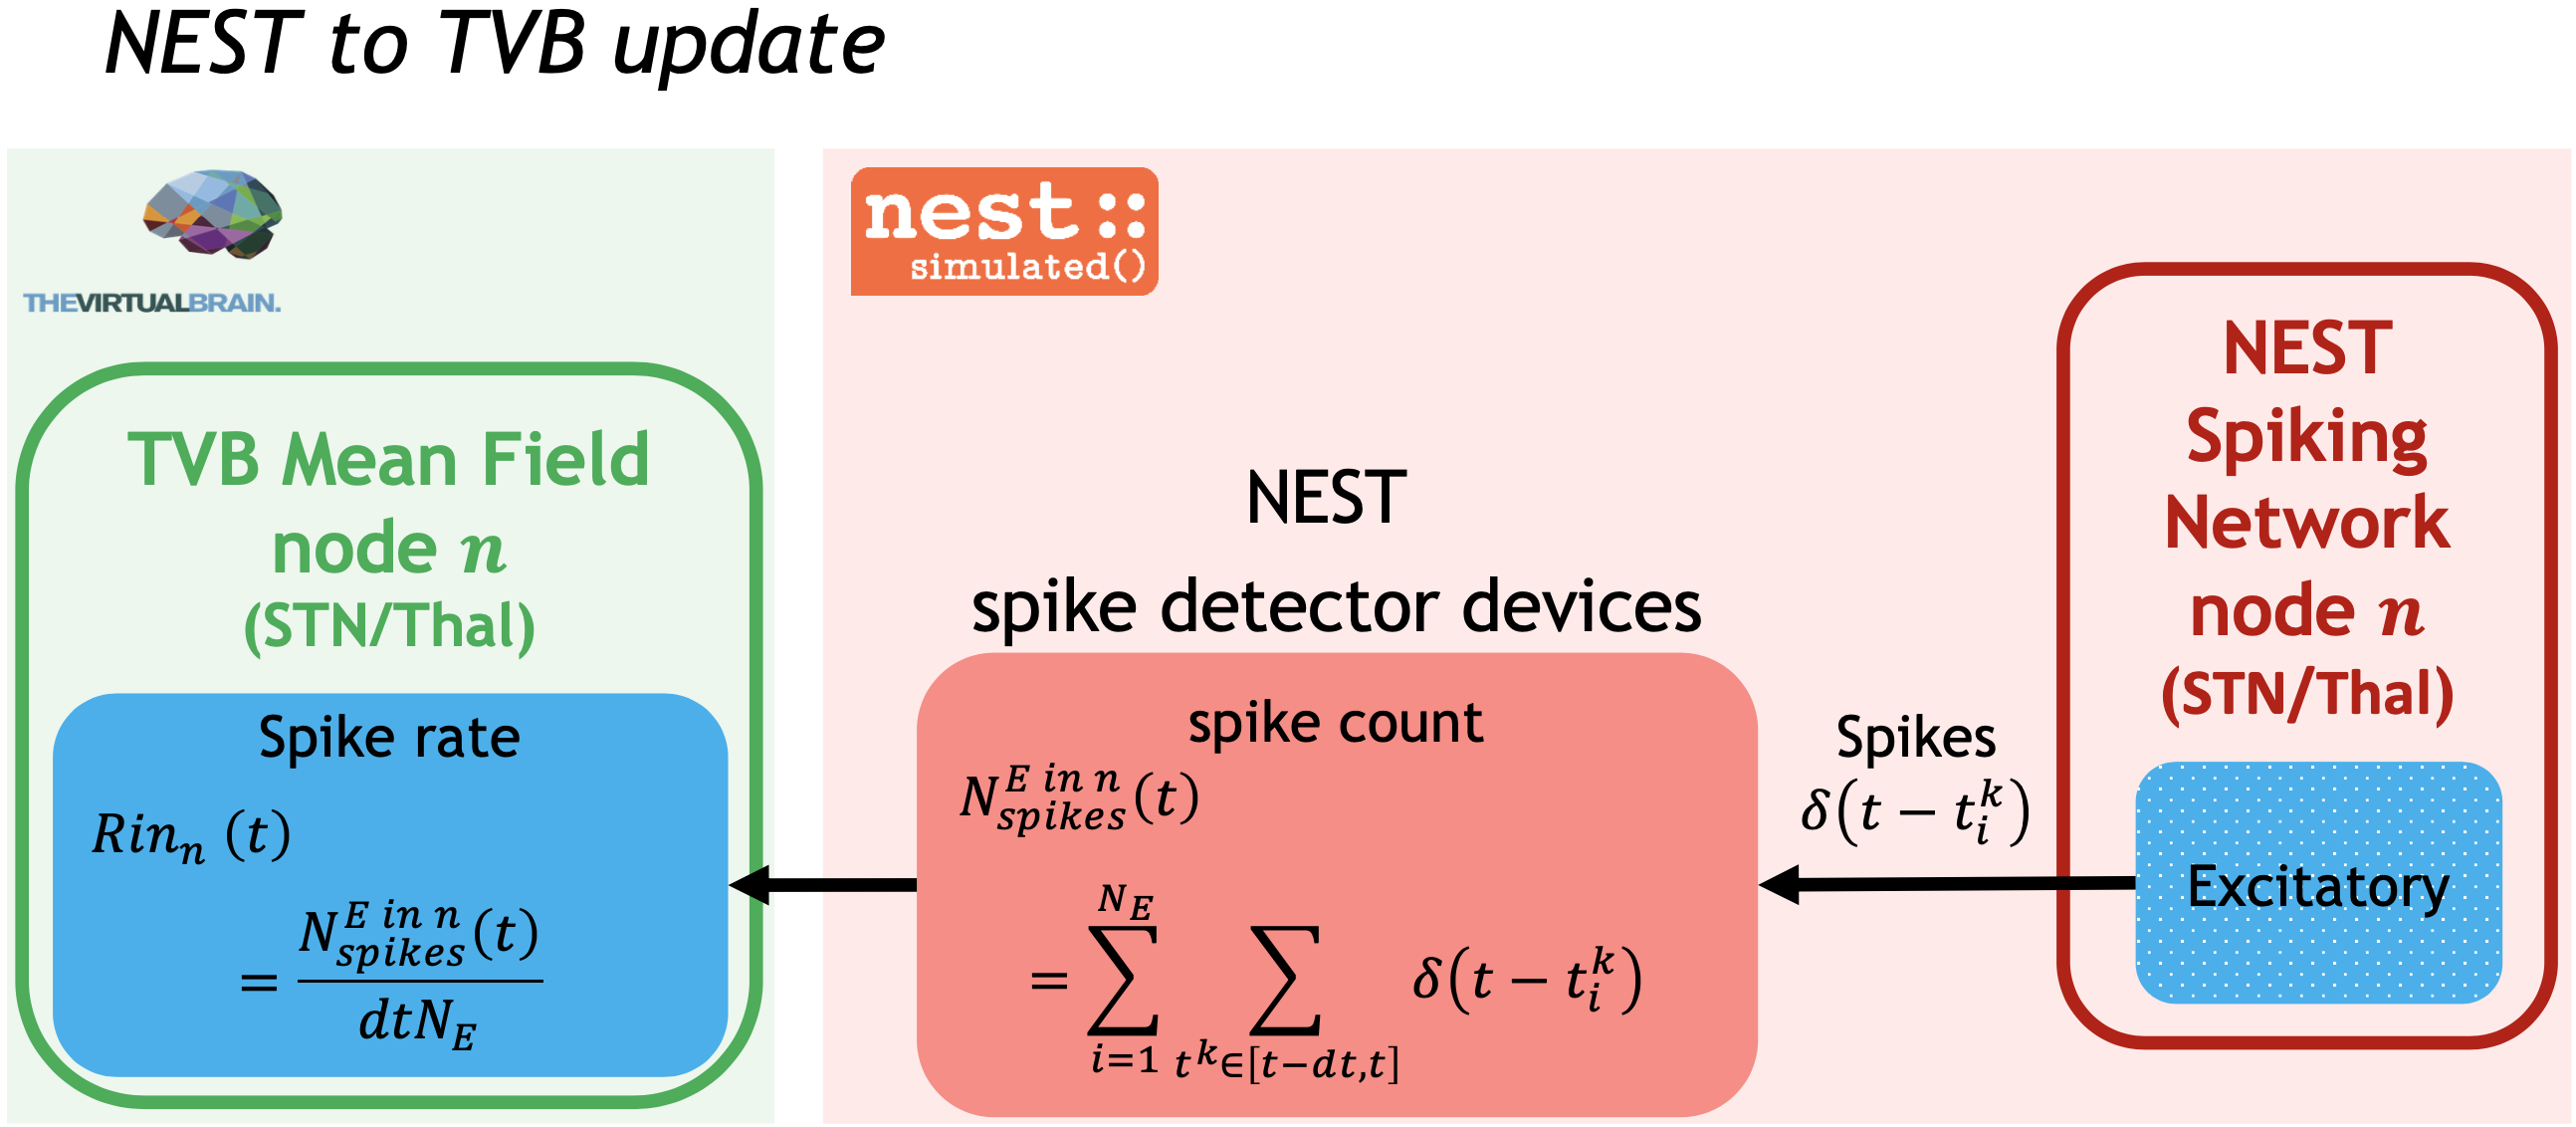

In [12]:
display(Image(filename='./pics/NESTtoTVB_BG.png',  width=1000, unconfined=False))

In [13]:
    
# TVB <-- NEST:
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
     # Loop for every different spike population and region combination:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, nest_model_builder.Istr_nodes_ids]):
        #            TVB <- NEST
        tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_recorder", "params": {},
        # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------
        #                     TVB <- NEST
             "connections": {"Rin": src_pop}, 
             "nodes": nodes})  # NEST regions nodes
    

In [14]:
# Finally build the TVB<->NEST interface model:
tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)


2021-01-22 18:17:28,510 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-01-22 18:17:28,510 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-01-22 18:17:28,512 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-01-22 18:17:28,512 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-01-22 18:17:28,525 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model dc_generator for S created!
2021-01-22 18:17:28,525 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model dc_generator for S created!
2021-01-22 18:17:30,749 - INFO - tvb_multiscale.core.spiking

In [15]:
# # Print a summary report of the TVB<->NEST interface model and, optionally, its connectivity:
print(tvb_nest_model.print_str(detailed_output=False, connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface


----------------------------------------------------------------------------------------------------


TVB to spikeNet interfaces:

----------------------------------------------------------------------------------------------------

Index: 0_S->['IdSN', 'IiSN']

TVBtoNESTDCGeneratorInterface
Name: S, TVB state variable indice: 0, 
Interface weights: [1.0]
Source TVB nodes' indices:
5...59 
Target NEST nodes' indices:
3 
----------------------------------------------------------------------------------------------------

Index: 1_S->E

TVBtoNESTDCGeneratorInterface
Name: S, TVB state variable indice: 0, 
Interface weights: [1.0]
Source TVB nodes' indices

## 4. Configure simulator, simulate, gather results

In [16]:
# Configure the simulator including the TVB-NEST interface model...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
simulation_length=220.0  # Set at least 1100.0 for a meaningful simulation
transient = simulation_length/11  # a transient to be removed for rate and correlation computations
t = time.time()
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))


Simulated in 118.512167 secs!


In [17]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [18]:
# Set plot_per_neuron to False for faster plotting of only mean field variables and dates:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [19]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts



/home/jovyan/packages/tvb-root/framework_tvb/tvb/core/utils.py:119: SyntaxWarning:"is" with a literal. Did you mean "=="?
/home/jovyan/packages/tvb-root/framework_tvb/tvb/core/neotraits/_h5core.py:338: SyntaxWarning:"is" with a literal. Did you mean "=="?


,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,2200
Region Mapping,None
Region Mapping Volume,None
Sample period,0.1
Source Connectivity,Connectivity gid: d4e6445a-9b8a-4d13-b238-cc7347423af4
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[0, 0.334525, 1000]"


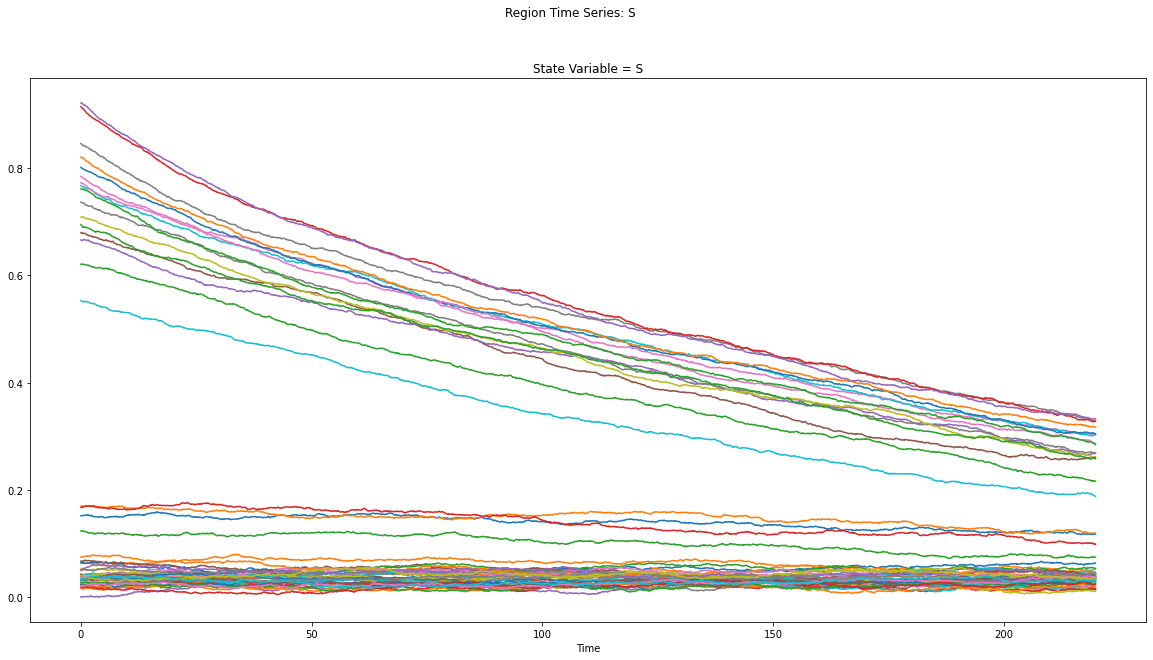

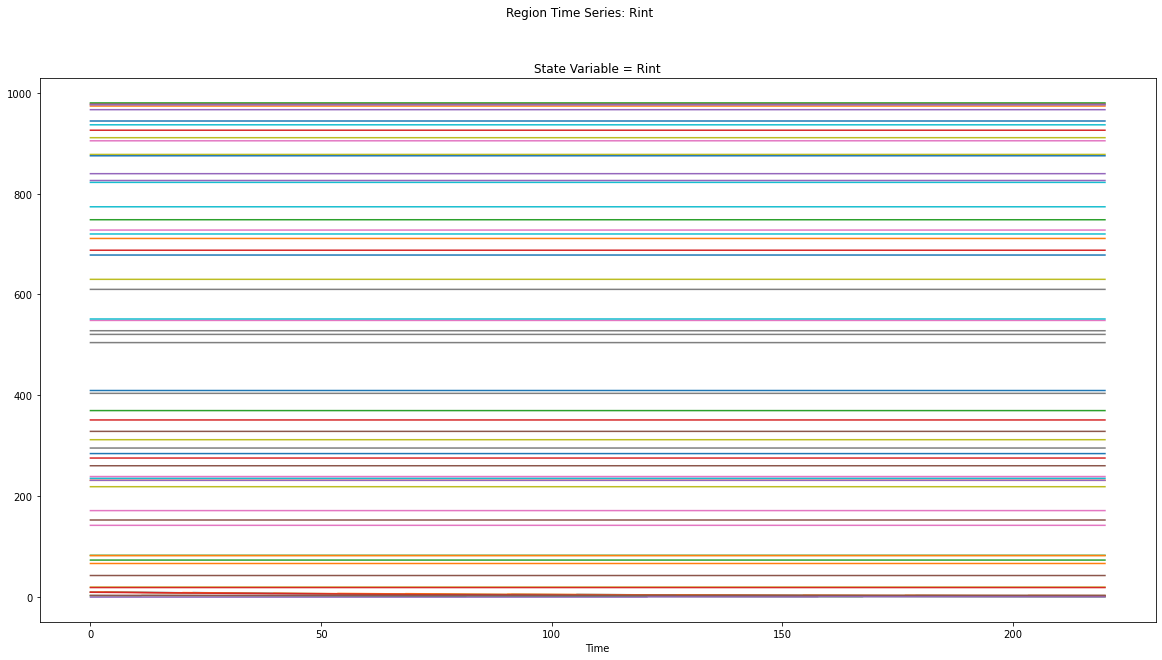

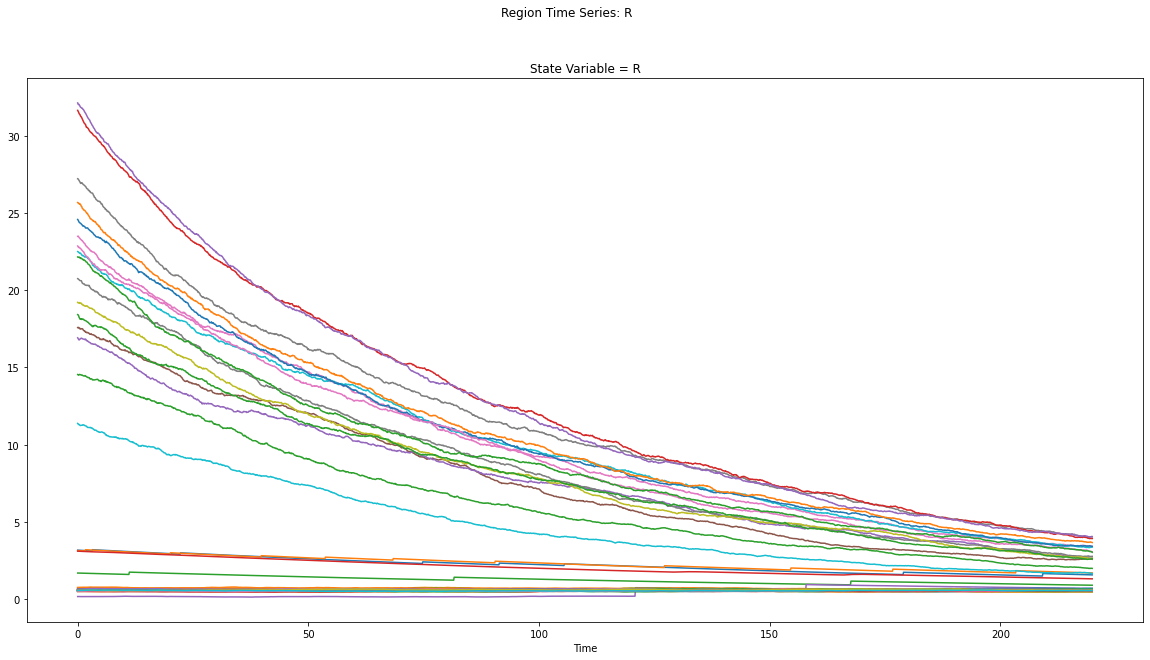

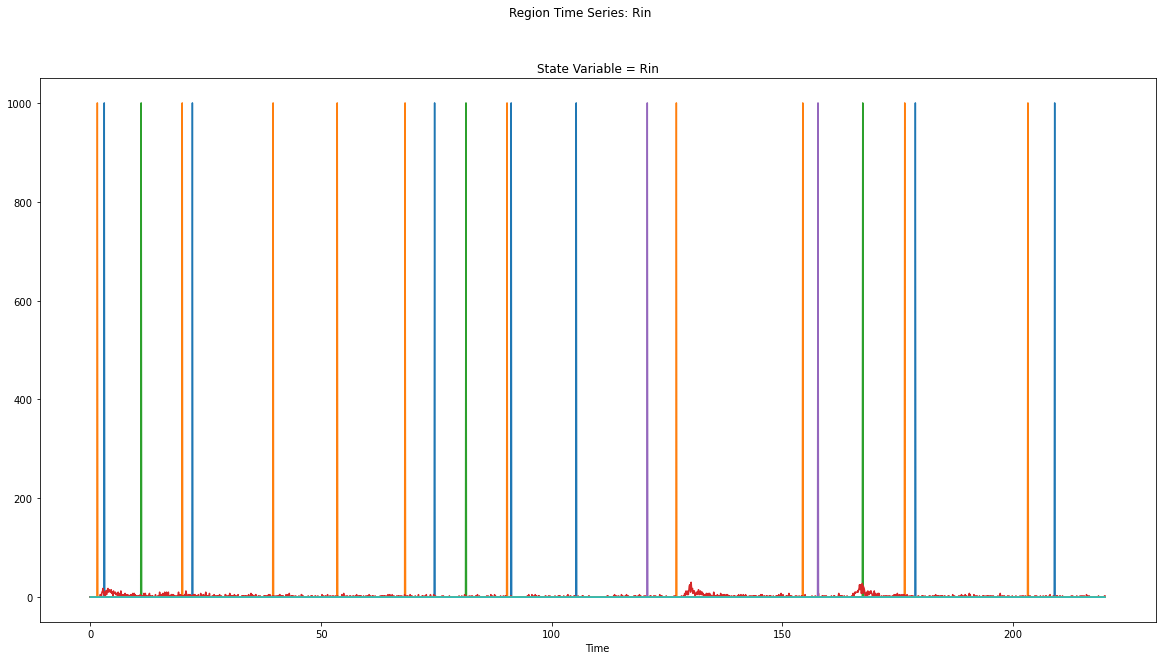

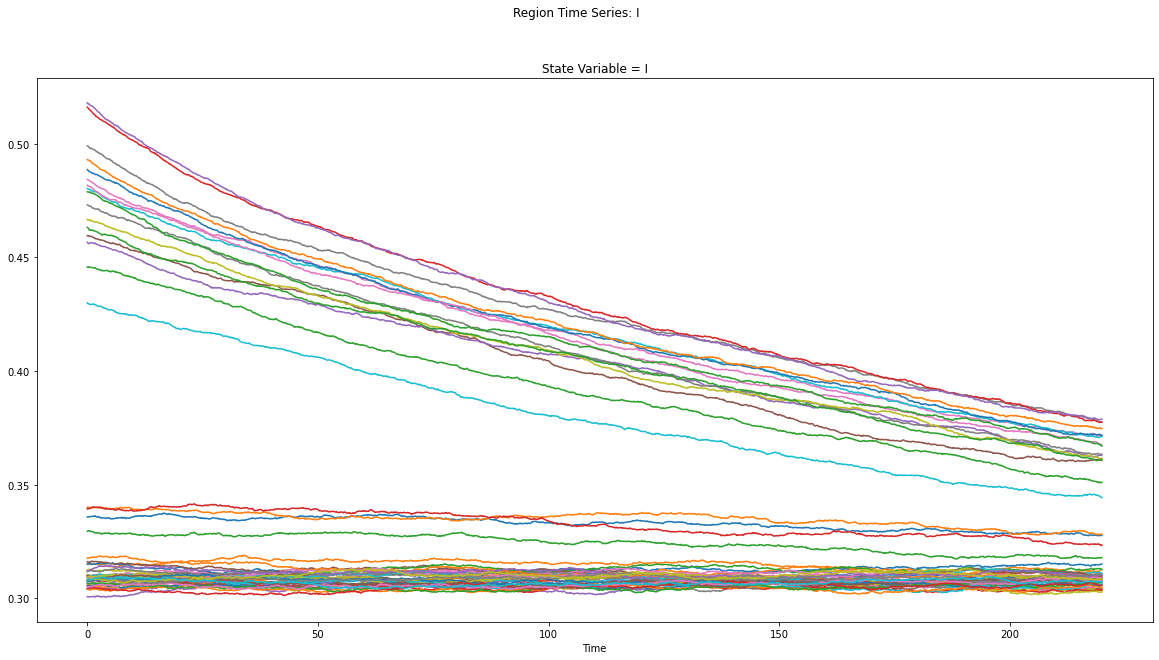

In [20]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [21]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-01-22 18:19:35,896 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-22 18:19:35,903 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-22 18:19:36,574 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-22 18:19:37,242 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-22 18:19:37,885 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-01-22 18:19:38,542 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


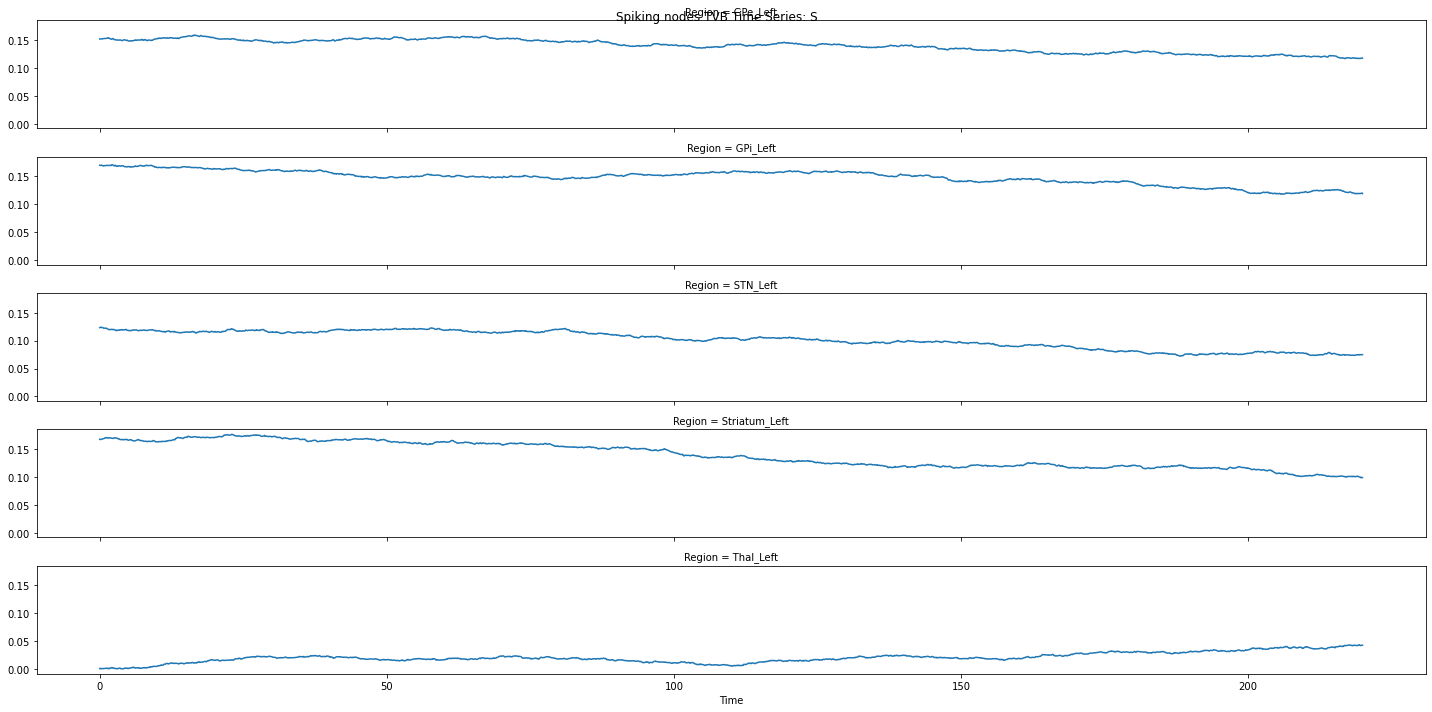

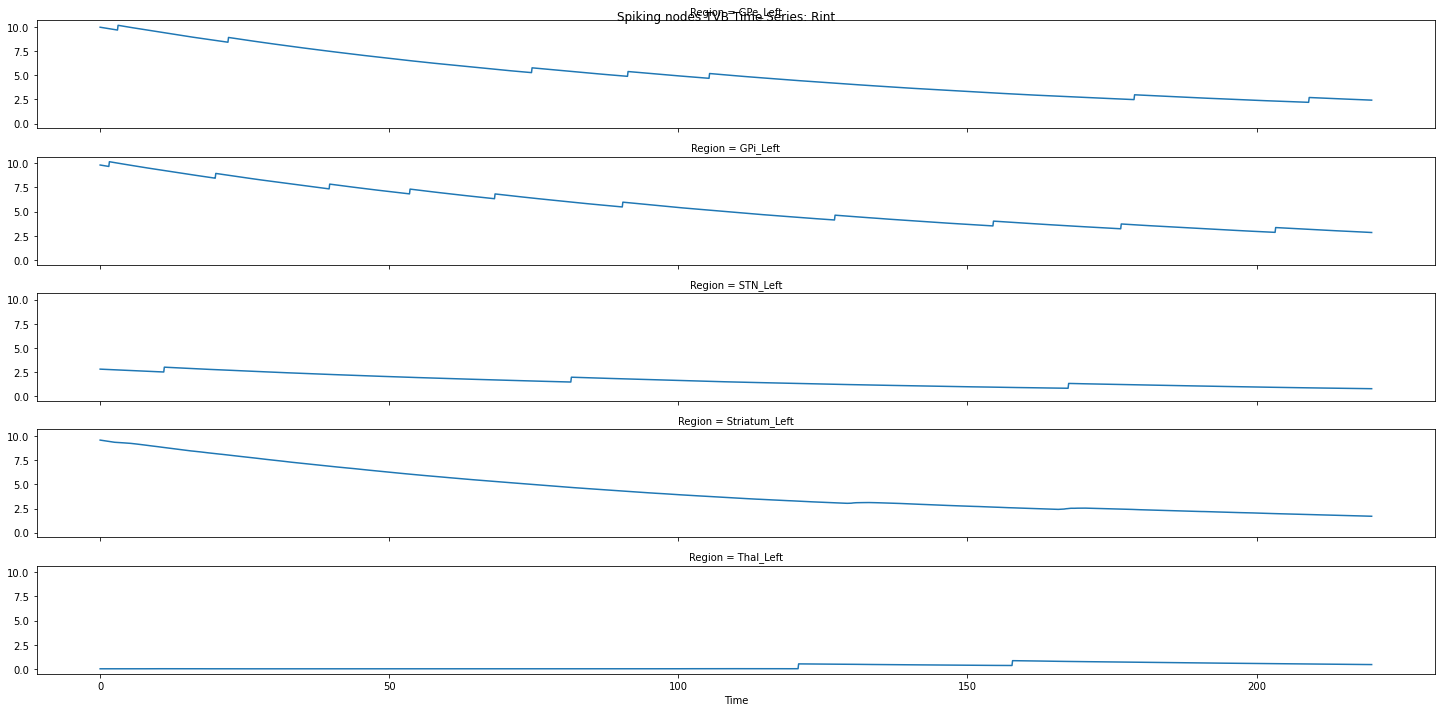

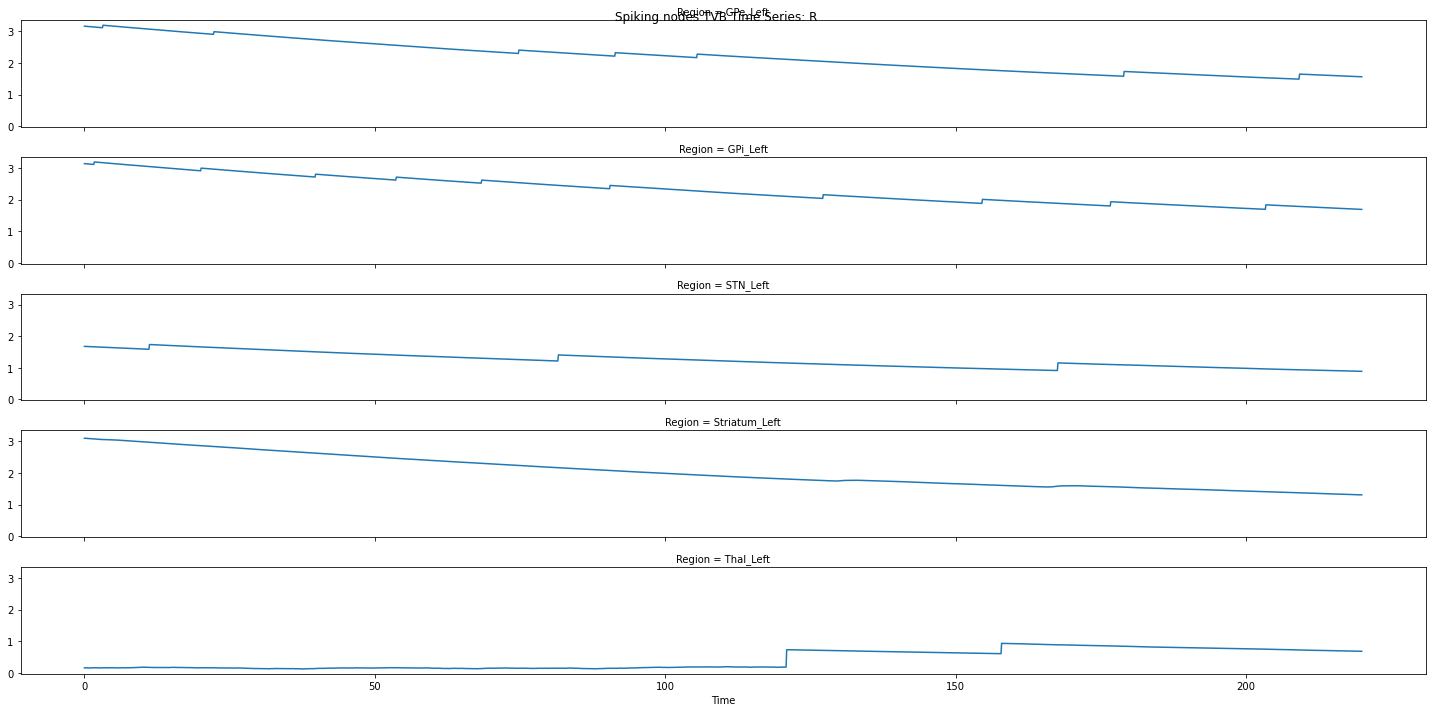

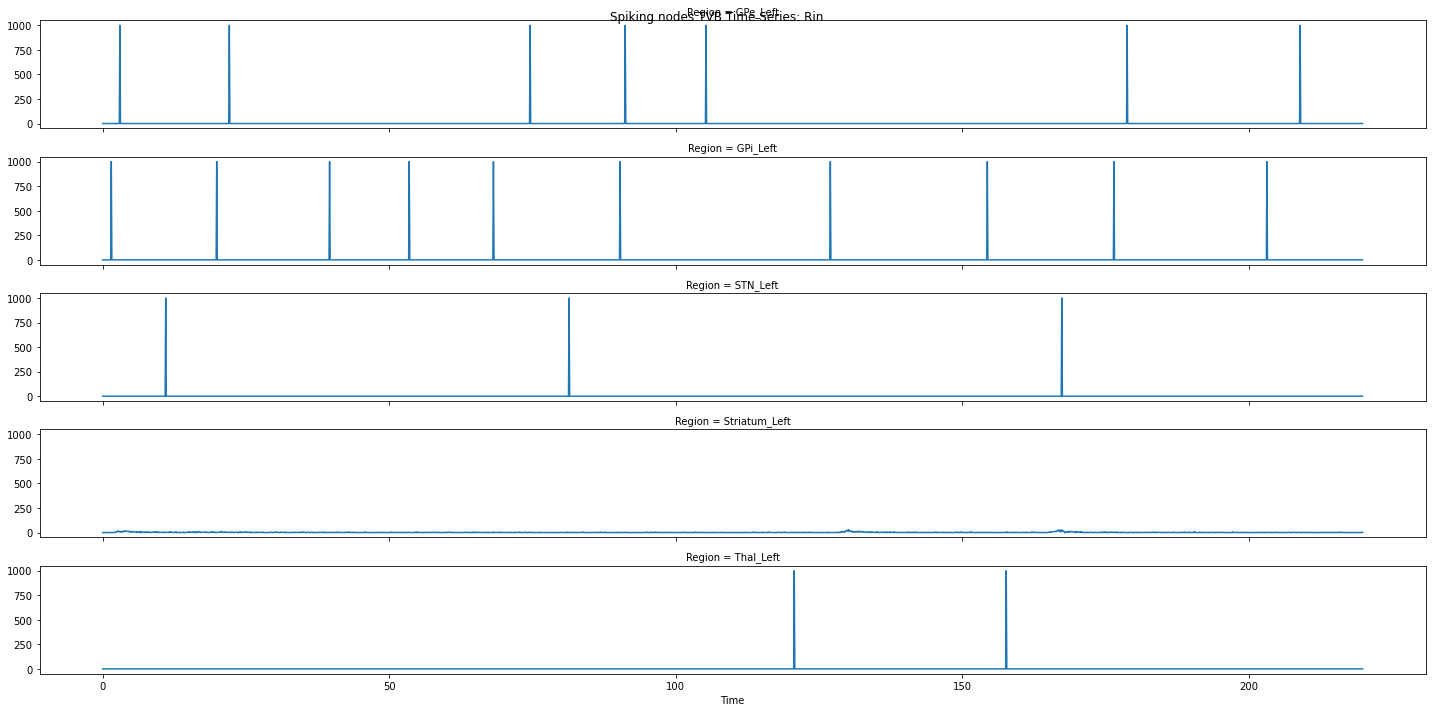

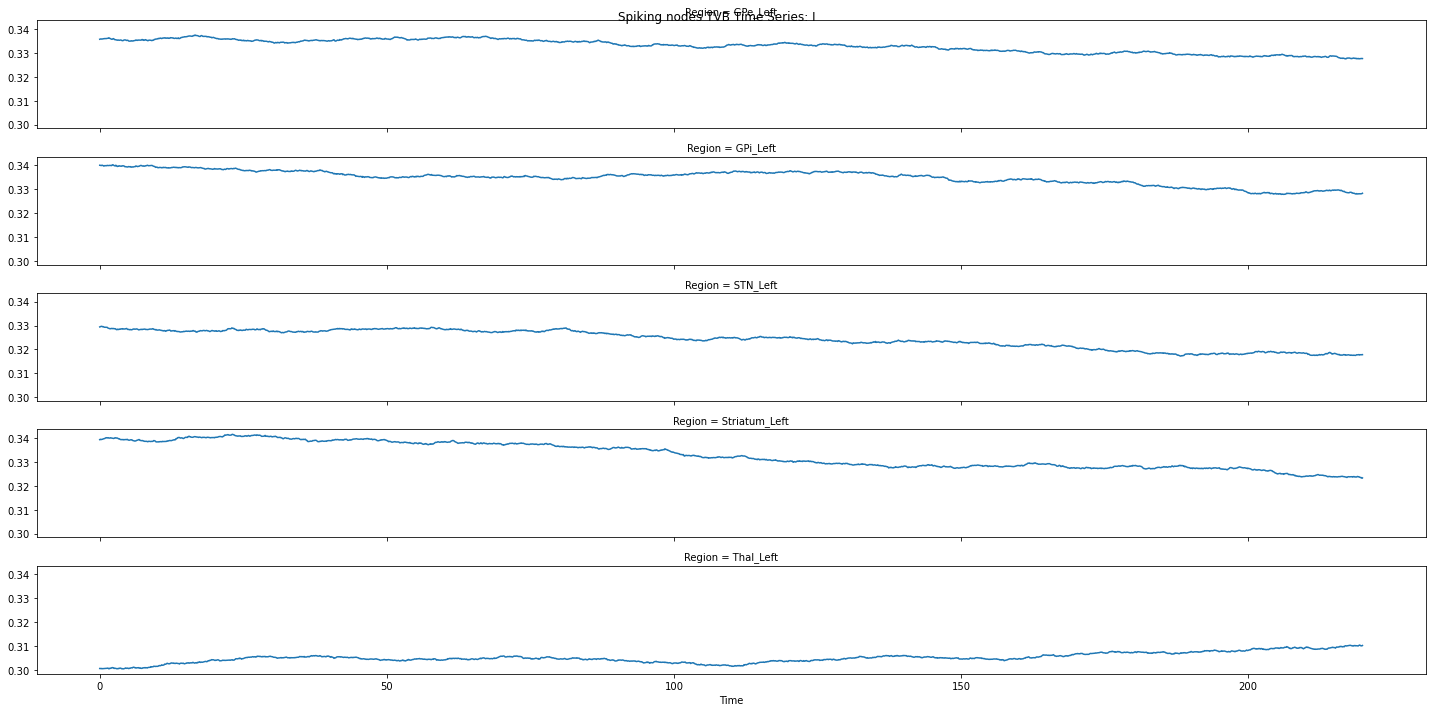

In [22]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [ ]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Spiking Network plots

In [23]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=t[0], end_time=t[-1], 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [24]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/opt/conda/lib/python3.8/site-packages/elephant/conversion.py:847: UserWarning:Binning discarded 200 last spike(s) of the input spiketrain


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 10.0050024 ,         nan, 10.0050024 ],
       [30.0150072 , 40.0200096 ,         nan,         nan,         nan],
       [        nan,         nan,         nan, 14.13206589,         nan],
       [        nan,         nan,         nan, 13.50675324,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,  1.00000000e+00,
                      nan, -8.97628457e-04],
         [            nan, 

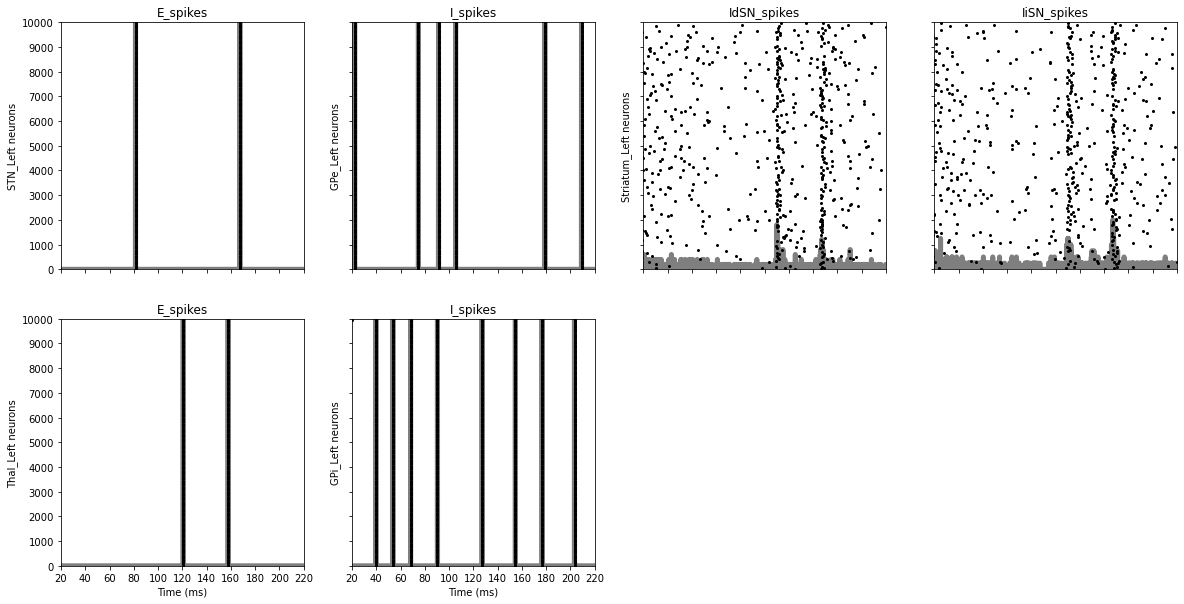

<Figure size 432x288 with 0 Axes>

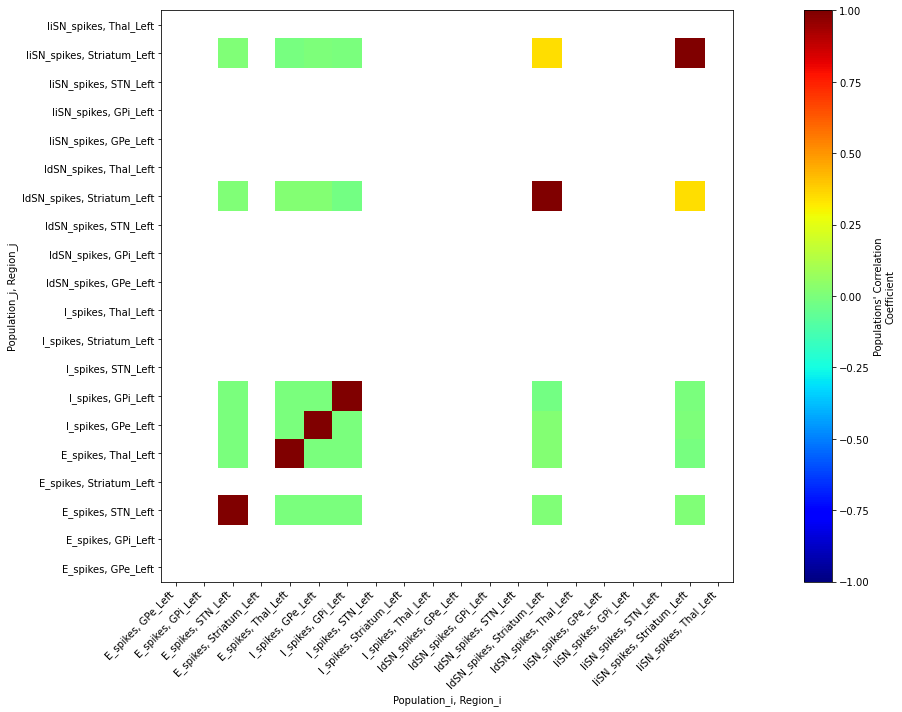

In [25]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], figsize=FIGSIZE) # 
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)
        
# !!! HOMEWORK !!!
# Copy the spike raster plot and paste it to the homework sheet 
# for items A12, A14 (C12, C14) and B10, B12 !!!

In [26]:
# Print the mean rates of the Striatum populations:
spikes_res["mean_rate"].loc[["IdSN_spikes", "IiSN_spikes"], "Striatum_Left"]

# !!! HOMEWORK !!!
# Copy the mean rate values and paste them to the HomeWork sheet 
# for items A13, A15 (C13, C15) and B11, B13 !!!

<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 2)>
array([14.13206589, 13.50675324])
Coordinates:
    Region      <U13 'Striatum_Left'
  * Population  (Population) object 'IdSN_spikes' 'IiSN_spikes'

In [ ]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

In [ ]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [ ]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [ ]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [ ]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>
  
3 Deco Gustavo, Ponce-Alvarez Adrian, Patric Hagmann, <br>
  Gian Luca Romani, Dante Mantini,and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 34(23), 7886-7898, 2014.<br>
  
4 Deco Gustavo, Ponce-Alvarez Adrian, Dante Mantini,<br>
  Gian Luca Romani, Patric Hagmann, and Maurizio Corbetta. <br>
  How local Excitation-Inhibition Ratio Impacts the Whole Brain Dynamics <br>
  The Journal of Neuroscience 33(27), 11239-11252, 2013.<br>

5 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

6 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
7 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868
  
8 Petersen Mikeel V, Mlakar Jeffrey, Haber Suzanne N, Parent Martin, <br>
  Smith Yoland, Strick Peter L, Griswold Mark A, McIntyre Cameron C (2019).<br>
  Holographic Reconstruction of Axonal Pathways in the Human Brain <br>
  Neuron. https://doi.org/10.1016/j.neuron.2019.09.030
  
  